<a href="https://colab.research.google.com/github/mathewhall100/Aerial-cactus-identification/blob/master/Kaggle_Aerial_Cactus_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle:  Aerial cactus identification challenge.

 Aim is to identify the presence or absence of cacti in aerial photos. 

## Notebook setup

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1

## Import Libraries

In [0]:
import os
import numpy as np
import pandas as pd
from fastai.vision import *
from fastai.metrics import accuracy

## Verify GPU status

In [5]:
print("PyTorch version - ", torch.__version__)
print("Cuda version - ", torch.version.cuda)
print("cuDNN version - ", torch.backends.cudnn.version())
print("Device - ", torch.device("cuda:0"))
print("python PIL version - ", PIL.PILLOW_VERSION)

PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
Device -  cuda:0
python PIL version -  4.3.0


##Download competition dataset from Kaggle

In [0]:
!pip install kaggle
# get kaggle api-token #
import json
import zipfile
# Create target Directory if doesn't exist
if not os.path.exists("/root/.kaggle"):
    os.mkdir("/root/.kaggle")
    print("Directory " , "/root/.kaggle" ,  " Created ")
else:    
    print("Directory " , "/root/.kaggle" ,  " already exists")
# Create kaggle.json file then write api_token into it
with open('/root/.kaggle/kaggle.json', 'w+') as file:
  json.dump(api_token, file)
# Important - change permissions of kaggle.json api_key not exposed to other users
!chmod 600 '/root/.kaggle/kaggle.json'
# Copy api from kaggle.com dataset
!kaggle competitions download -c aerial-cactus-identification


In [10]:
os.listdir()

['.config',
 'train.csv',
 'test.zip',
 'train.zip',
 'sample_submission.csv',
 'gdrive',
 'sample_data']

In [0]:
# Unzip all zipped files in the directory
for file in os.listdir():
  if zipfile.is_zipfile(file):
    zip_ref = zipfile.ZipFile(file,'r')
    zip_ref.extractall()
    zip_ref.close()

In [6]:
os.listdir()

['.config',
 'train',
 'train.csv',
 'test.zip',
 'test',
 'train.zip',
 'sample_submission.csv',
 'gdrive',
 'sample_data']

## Define parameters

In [0]:
bs = 64

In [0]:
data_path = "/content/"
data_path_train = data_path + "train/"
data_path_test = data_path + "test/"

## Load  data

In [0]:
df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'sample_submission.csv')


In [16]:
df_train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [17]:
df_test.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


## Create ImageDataBunch object

In [0]:
data = ImageDataBunch.from_df(data_path_train, df_train, ds_tfms=get_transforms(), bs=64).normalize()

In [0]:
data.add_test(ImageList.from_df(df_test, path=data_path_test))

In [33]:
data


ImageDataBunch;

Train: LabelList (14000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
1,1,1,0,1
Path: /content/train;

Valid: LabelList (3500 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
0,1,1,1,1
Path: /content/train;

Test: LabelList (4000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: EmptyLabelList
,,,,
Path: /content/train

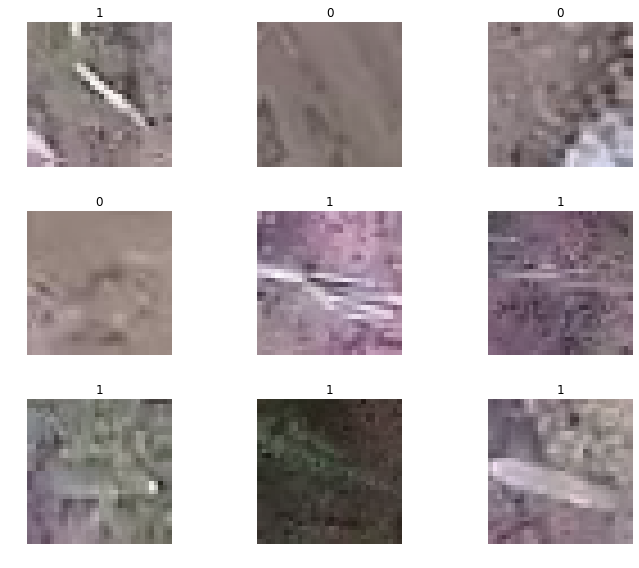

In [21]:
data.show_batch(rows=3, figsize=(10,8))

## Learn with resnet34

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 19922306.73it/s]


In [0]:
learn.model

In [24]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.236414,0.174824,0.943143,00:22
1,0.149013,0.135029,0.952286,00:20
2,0.107689,0.073323,0.976857,00:22
3,0.083994,0.062930,0.976000,00:20
4,0.084016,0.060883,0.977429,00:20


## Save model "stage1"

In [0]:
learn.save('stage1')

## Analyse results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

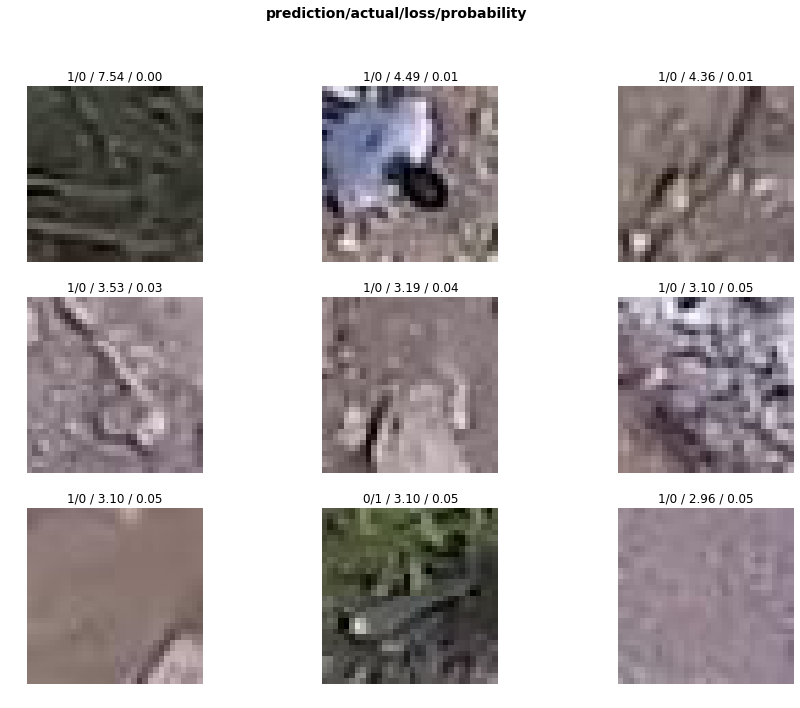

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

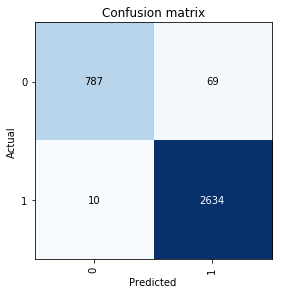

In [28]:
interp.plot_confusion_matrix()

## Determine learning rate and repeat

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


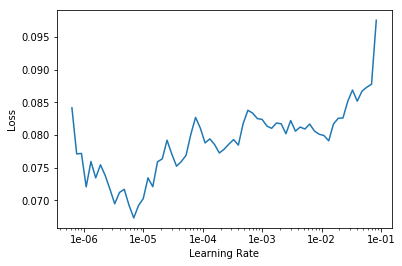

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(5, max_lr=1e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.083182,0.065884,0.974286,00:18
1,0.066701,0.063712,0.976857,00:21
2,0.072877,0.068715,0.973429,00:19
3,0.080719,0.063377,0.976000,00:21
4,0.078552,0.055450,0.979714,00:19


## Unfreeze and repeat

In [41]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.066889,0.061183,0.977143,00:19
1,0.071438,0.056867,0.979429,00:22
2,0.078850,0.063408,0.974857,00:20
3,0.067663,0.051324,0.980000,00:20
4,0.072756,0.050651,0.981714,00:20


In [47]:
learn.fit_one_cycle(10, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.043233,0.044790,0.982000,00:20
1,0.055287,0.039923,0.983143,00:20
2,0.054094,0.047156,0.981714,00:22
3,0.056644,0.035054,0.985429,00:22
4,0.051581,0.029919,0.988000,00:20
5,0.041660,0.033509,0.986286,00:19
6,0.049908,0.040144,0.984571,00:20
7,0.046246,0.035730,0.985143,00:22
8,0.040029,0.045896,0.983143,00:19
9,0.038879,0.030349,0.988286,00:19


##  Analyse results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

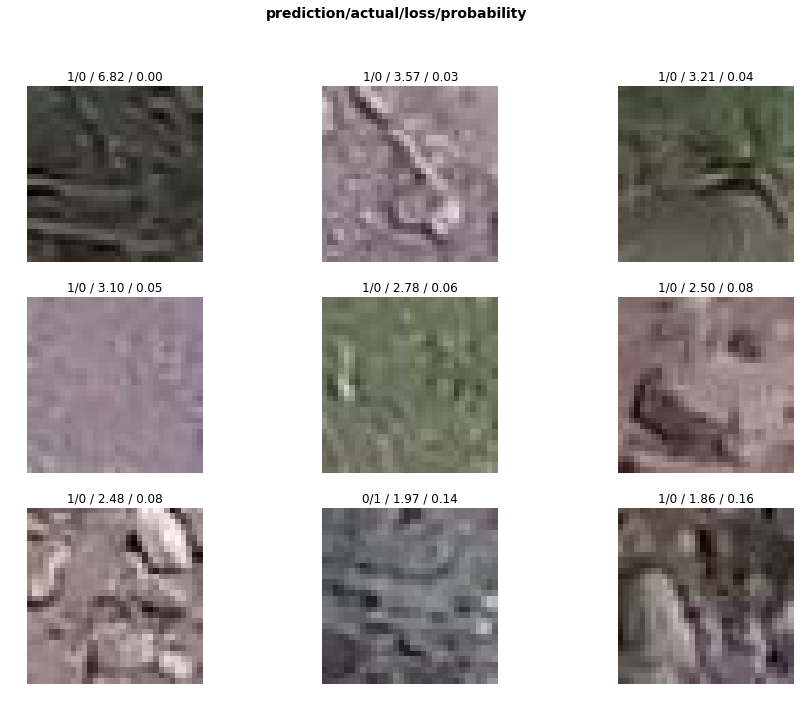

In [50]:
interp.plot_top_losses(9, figsize=(15,11))


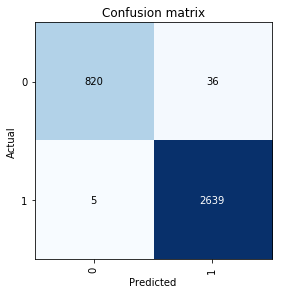

In [49]:
interp.plot_confusion_matrix()

## Save model

In [0]:
learn.save('stage2')

## Reduce dropout

The model is improving but the train loss is still greater than validation loss so assumption is we can increase performance by increasing capacity to learn by reducing dropout during training.

In [15]:
learn = cnn_learner(data, models.resnet34, ps=0.2, metrics=accuracy)
learn.model
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.600507,0.494212,0.790286,00:21
1,0.348324,0.252102,0.928286,00:21
2,0.163462,0.115885,0.963429,00:23
3,0.102273,0.063161,0.978857,00:21
4,0.061908,0.056611,0.978571,00:22
5,0.054125,0.030920,0.990571,00:23
6,0.044168,0.031356,0.990286,00:24
7,0.034792,0.039227,0.984571,00:22
8,0.034110,0.027235,0.990286,00:22
9,0.029459,0.025739,0.992571,00:24


In [44]:
learn = cnn_learner(data, models.resnet34, ps=0, metrics=accuracy)
learn.model
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-05, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.751719,0.813950,0.478857,00:23
1,0.607357,0.632336,0.627143,00:21
2,0.405222,0.377335,0.869143,00:21
3,0.227137,0.191027,0.956286,00:21
4,0.140521,0.108972,0.971714,00:23
5,0.087662,0.071889,0.978857,00:21
6,0.068049,0.053676,0.983143,00:21
7,0.049074,0.047255,0.983143,00:21
8,0.035269,0.037547,0.987714,00:23
9,0.046925,0.034833,0.989143,00:22


In [20]:
learn = cnn_learner(data, models.resnet34, ps=0.2, metrics=accuracy)
learn.model
learn.unfreeze()
learn.fit_one_cycle(25, max_lr=slice(1e-05, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.791877,0.750261,0.573143,00:21
1,0.636540,0.592123,0.699143,00:23
2,0.431141,0.378539,0.874571,00:21
3,0.257421,0.194896,0.958857,00:21
4,0.151552,0.111201,0.971714,00:21
5,0.098283,0.072741,0.979143,00:24
6,0.074035,0.055129,0.986000,00:21
7,0.068919,0.044623,0.986000,00:21
8,0.053359,0.035591,0.988571,00:23
9,0.040315,0.036356,0.986571,00:21


## Analyse results for improvement

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

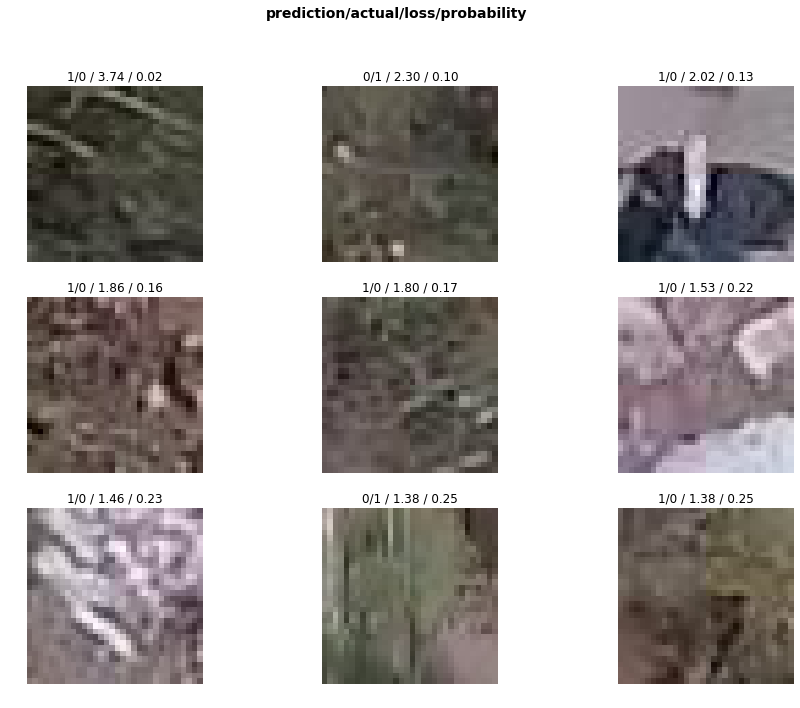

In [22]:
interp.plot_top_losses(9, figsize=(15,11))

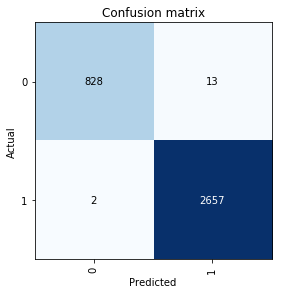

In [23]:
interp.plot_confusion_matrix()

## Save model

In [0]:
learn.save('stage3')

## Predictions on test set

In [0]:
predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

In [35]:
predictions[0]

tensor([2.4904e-04, 9.9975e-01])

In [36]:
predictions[:10]

tensor([[2.4904e-04, 9.9975e-01],
        [3.9000e-04, 9.9961e-01],
        [9.9999e-01, 9.4959e-06],
        [1.0000e+00, 3.2756e-08],
        [5.7043e-04, 9.9943e-01],
        [4.8267e-04, 9.9952e-01],
        [6.3841e-04, 9.9936e-01],
        [5.8257e-04, 9.9942e-01],
        [2.1468e-04, 9.9979e-01],
        [1.0000e+00, 2.5302e-09]])

In [0]:
predicted_classes = np.argmax(predictions, axis=1)

In [38]:
predicted_classes[:10]

tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

In [40]:
df_test['has_cactus'] = predicted_classes
df_test.head(10)

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1
5,0038ed6f7417b8275b393307f66cb1e3.jpg,1
6,0059dfa41de4441fc23b9a4b98ba99cb.jpg,1
7,0061bd302d735db829418cb90b4e6040.jpg,1
8,00754573d8c7223e73da553dd43780bd.jpg,1
9,008d9fce71c8e03a4c9cdd15ea908573.jpg,0
